# Info
RiJoshin, 2400013201;

人工智能基础第三次作业的实现，为方便图像显示与分模块修改

起于2025-04-03


## 第二课作业
用pytorch实现卷积神经网络，对cifar10数据集进行分类
要求:
1. 使用pytorch的nn.Module和Conv2d等相关的API实现卷积神经网络
2. 使用pytorch的DataLoader和Dataset等相关的API实现数据集的加载
3. 修改网络结构和参数，观察训练效果
4. 使用数据增强，提高模型的泛化能力



In [1]:
# import necessary packages
import os
import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm import tqdm
# plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime
import random
import string
import numpy as np

## 超参数

In [ ]:
# 定义超参数
hyperparameters = {
    'batch_size': 128,
    'learning_rate': 0.001,
    'num_epochs': 100,
    'early_stop_patience': 10
}
EARLY_STOP = True
DEBUG = False


## 数据裁剪

In [3]:

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])
# 数据增强的数据预处理方式
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))  # 归一化
])



## 可视化训练过程

In [4]:

def visualize_training_progress(train_acc_list, train_loss_list, test_acc_list,
                                hyperparameters=None, model_architecture=None, 
                                description="", save_dir="training_logs", 
                                show_plot=True):
    """
    可视化训练过程的准确率和损失，并自动保存图表和相关参数。
    
    参数:
    - train_acc_list: 每个epoch的训练准确率列表
    - train_loss_list: 每个epoch的训练损失列表
    - test_acc_list: 每个epoch的测试准确率列表
    - hyperparameters: 超参数字典
    - model_architecture: 模型架构描述
    - description: 实验描述
    - save_dir: 保存图表和日志的目录
    - show_plot: 是否显示图表
    """
    
    # 创建保存目录
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # 生成唯一的文件名
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
    file_prefix = f"{timestamp}_{random_str}"
    
    # 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
    
    # 绘制准确率
    epochs = np.arange(1, len(train_acc_list) + 1)
    ax1.plot(epochs, train_acc_list, 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, test_acc_list, 'r--', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 绘制损失
    ax2.plot(epochs, train_loss_list, 'g-', label='Training Loss', linewidth=2)
    ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 添加描述信息
    fig.suptitle(f'Training Progress - {description}', fontsize=16, fontweight='bold')
    
    # 保存图表
    plot_filename = os.path.join(save_dir, f"{file_prefix}_training_progress.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    
    # 保存超参数和模型架构
    info_filename = os.path.join(save_dir, f"{file_prefix}_training_info.txt")
    with open(info_filename, 'w') as f:
        f.write(f"Training Progress Summary - {description}\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        
        if hyperparameters:
            f.write("Hyperparameters:\n")
            for key, value in hyperparameters.items():
                f.write(f"  {key}: {value}\n")
            f.write("\n")
        
        if model_architecture:
            f.write("Model Architecture:\n")
            f.write(f"{model_architecture}\n")
            f.write("\n")
        
        f.write("Training Accuracy: \n")
        f.write(f"{train_acc_list}\n\n")
        
        f.write("Training Loss: \n")
        f.write(f"{train_loss_list}\n\n")
        
        f.write("Validation Accuracy: \n")
        f.write(f"{test_acc_list}\n\n")

    
    if show_plot:
        plt.show()
    
    print(f"Training progress visualization saved to: {plot_filename}")
    print(f"Training information saved to: {info_filename}")
    # return plot_filename, info_filename

## load data

In [5]:

# 定义数据集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

## Models


### Normal VGG

In [ ]:

# 定义模型
class Net(nn.Module):
    '''
    定义卷积神经网络,3个卷积层,2个全连接层
    '''
    def __init__(self, height, width):
        super(Net, self).__init__()

        self.image_height = height
        self.image_width = width

        # 先写死，后面改成根据输入参数构建网络维度的 TODO 最多5层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # 3, H, W -> 32, H, W
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 32, H/2, W/2 -> 64, H/2, W/2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # 64, H/4, W/4 -> 128, H/4, W/4
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # 128, H/8, W/8 -> 256, H/8, W/8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # 256, H/16, W/16 -> 512, H/16, W/16
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.fc = nn.Sequential(
            # 似乎不需要汇总了
            nn.Linear(512 * (height // 32) * (width // 32), 2048), \
            nn.ReLU(inplace=True), 
            nn.Dropout(),
            nn.Linear(2048, 10), # 512 -> 10
            nn.Softmax(dim=1) # 10 -> 10
        )
    
    def forward(self, x: torch.Tensor):
        '''
        Args:
            x: tensor, shape [batch_size, 3, H, W]
        '''
        res = self.conv(x)
        if DEBUG:
            print("conv output shape: ", res.shape)
        res = res.view(res.size(0), -1)
        if DEBUG:
            print("conv flatten output shape: ", res.shape)
        res = self.fc(res)
        return res

### ResNet

In [7]:

# ResNet
class BasicBlockForResNet(nn.Module):
    expansion = 1 # in_channel = expansion * out_channel
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockForResNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) # !!!!!! TODO important
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) 

        self.shortcut = nn.Sequential() 
        if stride != 1 or in_channels != self.expansion * out_channels: # TODO
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,  self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True) # inplace=True, 直接在原来的内存上进行操作，节省内存开销

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x))) 
        out = self.bn2(self.conv2(out)) 
        out += self.shortcut(x) # 残差连接
        out = self.relu(out)
        return out

class ResNetTest(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetTest, self).__init__()


        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)

        # Kaiming初始化 # TODO 初始化，来自PPT    
        # 权重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 构建多个残差块
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x))) 
        out = self.layer1(out) 
        out = self.layer2(out) 
        out = self.layer3(out) 
        out = self.layer4(out)  
        out = self.avg_pool(out) 
        out = out.view(out.size(0), -1) 
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Model的实例化

In [8]:

# 实例化模型
model = Net(32, 32)
# model = ResNetTest(BasicBlockForResNet, [2, 2, 2, 2])

## Device

In [9]:

use_mlu = False # 爱了学长，喜欢这个判断
try:
    use_mlu = torch.mlu.is_available()
except:
    use_mlu = False

if use_mlu:
    device = torch.device('mlu:0')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    print(f'MLU is not available, use {device} instead.')

model = model.to(device)

MLU is not available, use cuda:0 instead.


## 选择lossFunction 以及 optimizer

In [10]:

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=5e-4) ## TODO


## Training!

### train function


In [11]:
def train_model(epoch):
    '''
    Args:
        epoch (int): 当前epoch次数
    Returns:
        并非list
        accuracie (Tensor): 本轮最后次统计的正确率
        losses     (Tensor): 同, loss
    '''
    # 训练模式
    model.train()
    accuracies = None
    losses = None
    # 使用 tqdm 包装数据加载器，显示训练进度
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{hyperparameters['num_epochs']}", unit="batch")
    
    for i, (images, labels) in enumerate(progress_bar):

        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (outputs.argmax(1) == labels).float().mean()

        # 打印训练信息
        if (i + 1) % 100 == 0:
            accuracies = accuracy.item()
            losses = loss.item()
            # 更新进度条信息
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Accuracy": f"{accuracy.item():.4f}"
            })

    return accuracies, losses
        

### test function

In [12]:
def test_model(epoch):
    '''
    没有传参数model, 把model当全局变量用了, 这样写的少些(其实是为了改回py文件时候好改, 只用复制粘贴就行, 不想起新名字折腾变量声明域了)
    Returns:
        test_acc (double): 测试正确率
    '''
    # 测试模式
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = correct / total

        print( f'    Epoch {epoch}/{ hyperparameters["num_epochs"] } TestAccuracy: {test_acc:.2f}' )
        return test_acc
        # test_log = 'Test Accuracy of the model on the 10000 test images: {} %'.format(test_acc)
        # print(test_log)

### train的主循环

Epoch 1/100: 100%|██████████| 782/782 [00:06<00:00, 123.99batch/s, Loss=1.9839, Accuracy=0.5000]


    Epoch 0/100 TestAccuracy: 0.26


Epoch 2/100: 100%|██████████| 782/782 [00:05<00:00, 130.54batch/s, Loss=2.0320, Accuracy=0.4062]


    Epoch 1/100 TestAccuracy: 0.43


Epoch 3/100: 100%|██████████| 782/782 [00:05<00:00, 131.04batch/s, Loss=1.8865, Accuracy=0.5781]


    Epoch 2/100 TestAccuracy: 0.52


Epoch 4/100: 100%|██████████| 782/782 [00:06<00:00, 129.40batch/s, Loss=1.9028, Accuracy=0.5781]


    Epoch 3/100 TestAccuracy: 0.51


Epoch 5/100: 100%|██████████| 782/782 [00:06<00:00, 129.06batch/s, Loss=1.8648, Accuracy=0.5781]


    Epoch 4/100 TestAccuracy: 0.55


Epoch 6/100: 100%|██████████| 782/782 [00:06<00:00, 128.88batch/s, Loss=1.7624, Accuracy=0.7188]


    Epoch 5/100 TestAccuracy: 0.57


Epoch 7/100: 100%|██████████| 782/782 [00:06<00:00, 130.05batch/s, Loss=1.8667, Accuracy=0.5938]


    Epoch 6/100 TestAccuracy: 0.59


Epoch 8/100: 100%|██████████| 782/782 [00:06<00:00, 129.89batch/s, Loss=1.7165, Accuracy=0.7344]


    Epoch 7/100 TestAccuracy: 0.67


Epoch 9/100: 100%|██████████| 782/782 [00:06<00:00, 129.26batch/s, Loss=1.9190, Accuracy=0.5625]


    Epoch 8/100 TestAccuracy: 0.68


Epoch 10/100: 100%|██████████| 782/782 [00:06<00:00, 128.29batch/s, Loss=1.7021, Accuracy=0.7344]


    Epoch 9/100 TestAccuracy: 0.68


Epoch 11/100: 100%|██████████| 782/782 [00:06<00:00, 129.80batch/s, Loss=1.7805, Accuracy=0.6719]


    Epoch 10/100 TestAccuracy: 0.70


Epoch 12/100: 100%|██████████| 782/782 [00:06<00:00, 129.95batch/s, Loss=1.7436, Accuracy=0.7188]


    Epoch 11/100 TestAccuracy: 0.71


Epoch 13/100: 100%|██████████| 782/782 [00:06<00:00, 129.53batch/s, Loss=1.7616, Accuracy=0.7031]


    Epoch 12/100 TestAccuracy: 0.72


Epoch 14/100: 100%|██████████| 782/782 [00:06<00:00, 129.34batch/s, Loss=1.7710, Accuracy=0.7188]


    Epoch 13/100 TestAccuracy: 0.73


Epoch 15/100: 100%|██████████| 782/782 [00:06<00:00, 129.80batch/s, Loss=1.8258, Accuracy=0.6094]


    Epoch 14/100 TestAccuracy: 0.69


Epoch 16/100: 100%|██████████| 782/782 [00:06<00:00, 129.97batch/s, Loss=1.7661, Accuracy=0.7031]


    Epoch 15/100 TestAccuracy: 0.73


Epoch 17/100: 100%|██████████| 782/782 [00:06<00:00, 129.93batch/s, Loss=1.7626, Accuracy=0.7031]


    Epoch 16/100 TestAccuracy: 0.73


Epoch 18/100: 100%|██████████| 782/782 [00:06<00:00, 129.93batch/s, Loss=1.6171, Accuracy=0.8281]


    Epoch 17/100 TestAccuracy: 0.71


Epoch 19/100: 100%|██████████| 782/782 [00:06<00:00, 130.25batch/s, Loss=1.7937, Accuracy=0.6562]


    Epoch 18/100 TestAccuracy: 0.74


Epoch 20/100: 100%|██████████| 782/782 [00:05<00:00, 131.06batch/s, Loss=1.7495, Accuracy=0.7188]


    Epoch 19/100 TestAccuracy: 0.74


Epoch 21/100: 100%|██████████| 782/782 [00:06<00:00, 129.91batch/s, Loss=1.6438, Accuracy=0.8125]


    Epoch 20/100 TestAccuracy: 0.75


Epoch 22/100: 100%|██████████| 782/782 [00:06<00:00, 130.06batch/s, Loss=1.7614, Accuracy=0.7031]


    Epoch 21/100 TestAccuracy: 0.71


Epoch 23/100: 100%|██████████| 782/782 [00:05<00:00, 133.18batch/s, Loss=1.7175, Accuracy=0.7344]


    Epoch 22/100 TestAccuracy: 0.71


Epoch 24/100: 100%|██████████| 782/782 [00:05<00:00, 132.96batch/s, Loss=1.7438, Accuracy=0.7031]


    Epoch 23/100 TestAccuracy: 0.74


Epoch 25/100: 100%|██████████| 782/782 [00:05<00:00, 133.22batch/s, Loss=1.7458, Accuracy=0.7031]


    Epoch 24/100 TestAccuracy: 0.76


Epoch 26/100: 100%|██████████| 782/782 [00:05<00:00, 133.09batch/s, Loss=1.6484, Accuracy=0.8125]


    Epoch 25/100 TestAccuracy: 0.74


Epoch 27/100: 100%|██████████| 782/782 [00:05<00:00, 133.14batch/s, Loss=1.6667, Accuracy=0.7969]


    Epoch 26/100 TestAccuracy: 0.75


Epoch 28/100: 100%|██████████| 782/782 [00:05<00:00, 133.00batch/s, Loss=1.7522, Accuracy=0.7188]


    Epoch 27/100 TestAccuracy: 0.75


Epoch 29/100: 100%|██████████| 782/782 [00:05<00:00, 133.08batch/s, Loss=1.7170, Accuracy=0.7500]


    Epoch 28/100 TestAccuracy: 0.76


Epoch 30/100: 100%|██████████| 782/782 [00:05<00:00, 133.12batch/s, Loss=1.6214, Accuracy=0.8438]


    Epoch 29/100 TestAccuracy: 0.76


Epoch 31/100: 100%|██████████| 782/782 [00:05<00:00, 133.07batch/s, Loss=1.6971, Accuracy=0.7656]


    Epoch 30/100 TestAccuracy: 0.77


Epoch 32/100: 100%|██████████| 782/782 [00:05<00:00, 131.18batch/s, Loss=1.7025, Accuracy=0.7656]


    Epoch 31/100 TestAccuracy: 0.74


Epoch 33/100: 100%|██████████| 782/782 [00:05<00:00, 133.09batch/s, Loss=1.6292, Accuracy=0.8438]


    Epoch 32/100 TestAccuracy: 0.75


Epoch 34/100: 100%|██████████| 782/782 [00:06<00:00, 129.93batch/s, Loss=1.6692, Accuracy=0.7812]


    Epoch 33/100 TestAccuracy: 0.74


Epoch 35/100: 100%|██████████| 782/782 [00:06<00:00, 130.25batch/s, Loss=1.7086, Accuracy=0.7500]


    Epoch 34/100 TestAccuracy: 0.76


Epoch 36/100: 100%|██████████| 782/782 [00:06<00:00, 130.28batch/s, Loss=1.6713, Accuracy=0.7969]


    Epoch 35/100 TestAccuracy: 0.76


Epoch 37/100: 100%|██████████| 782/782 [00:05<00:00, 133.31batch/s, Loss=1.6898, Accuracy=0.7500]


    Epoch 36/100 TestAccuracy: 0.76


Epoch 38/100: 100%|██████████| 782/782 [00:05<00:00, 133.64batch/s, Loss=1.5809, Accuracy=0.8906]


    Epoch 37/100 TestAccuracy: 0.76


Epoch 39/100: 100%|██████████| 782/782 [00:05<00:00, 133.54batch/s, Loss=1.7034, Accuracy=0.7656]


    Epoch 38/100 TestAccuracy: 0.75


Epoch 40/100: 100%|██████████| 782/782 [00:06<00:00, 129.80batch/s, Loss=1.7714, Accuracy=0.6875]


    Epoch 39/100 TestAccuracy: 0.76


Epoch 41/100: 100%|██████████| 782/782 [00:05<00:00, 130.48batch/s, Loss=1.6880, Accuracy=0.7812]


    Epoch 40/100 TestAccuracy: 0.75


Epoch 42/100: 100%|██████████| 782/782 [00:06<00:00, 129.90batch/s, Loss=1.7289, Accuracy=0.7344]


    Epoch 41/100 TestAccuracy: 0.76


Epoch 43/100: 100%|██████████| 782/782 [00:06<00:00, 129.92batch/s, Loss=1.7122, Accuracy=0.7656]


    Epoch 42/100 TestAccuracy: 0.76


Epoch 44/100: 100%|██████████| 782/782 [00:06<00:00, 129.38batch/s, Loss=1.6377, Accuracy=0.8438]


    Epoch 43/100 TestAccuracy: 0.77


Epoch 45/100: 100%|██████████| 782/782 [00:06<00:00, 130.28batch/s, Loss=1.7323, Accuracy=0.7344]


    Epoch 44/100 TestAccuracy: 0.76


Epoch 46/100: 100%|██████████| 782/782 [00:05<00:00, 132.35batch/s, Loss=1.5738, Accuracy=0.8906]


    Epoch 45/100 TestAccuracy: 0.75


Epoch 47/100: 100%|██████████| 782/782 [00:05<00:00, 132.85batch/s, Loss=1.6790, Accuracy=0.7812]


    Epoch 46/100 TestAccuracy: 0.75


Epoch 48/100: 100%|██████████| 782/782 [00:06<00:00, 129.90batch/s, Loss=1.6723, Accuracy=0.7812]


    Epoch 47/100 TestAccuracy: 0.74


Epoch 49/100: 100%|██████████| 782/782 [00:05<00:00, 130.79batch/s, Loss=1.7101, Accuracy=0.7500]


    Epoch 48/100 TestAccuracy: 0.78


Epoch 50/100: 100%|██████████| 782/782 [00:05<00:00, 132.66batch/s, Loss=1.7028, Accuracy=0.7500]


    Epoch 49/100 TestAccuracy: 0.78


Epoch 51/100: 100%|██████████| 782/782 [00:05<00:00, 133.03batch/s, Loss=1.6060, Accuracy=0.8594]


    Epoch 50/100 TestAccuracy: 0.77


Epoch 52/100: 100%|██████████| 782/782 [00:05<00:00, 130.37batch/s, Loss=1.5796, Accuracy=0.8906]


    Epoch 51/100 TestAccuracy: 0.77


Epoch 53/100: 100%|██████████| 782/782 [00:05<00:00, 131.05batch/s, Loss=1.7395, Accuracy=0.7188]


    Epoch 52/100 TestAccuracy: 0.75


Epoch 54/100: 100%|██████████| 782/782 [00:05<00:00, 132.16batch/s, Loss=1.6241, Accuracy=0.8438]


    Epoch 53/100 TestAccuracy: 0.73


Epoch 55/100: 100%|██████████| 782/782 [00:06<00:00, 129.85batch/s, Loss=1.6808, Accuracy=0.7812]


    Epoch 54/100 TestAccuracy: 0.77


Epoch 56/100: 100%|██████████| 782/782 [00:06<00:00, 129.93batch/s, Loss=1.6999, Accuracy=0.7656]


    Epoch 55/100 TestAccuracy: 0.76


Epoch 57/100: 100%|██████████| 782/782 [00:06<00:00, 129.10batch/s, Loss=1.6438, Accuracy=0.7969]


    Epoch 56/100 TestAccuracy: 0.73


Epoch 58/100: 100%|██████████| 782/782 [00:06<00:00, 129.85batch/s, Loss=1.6166, Accuracy=0.8438]


    Epoch 57/100 TestAccuracy: 0.78


Epoch 59/100: 100%|██████████| 782/782 [00:06<00:00, 129.81batch/s, Loss=1.6817, Accuracy=0.7812]


    Epoch 58/100 TestAccuracy: 0.76


Epoch 60/100: 100%|██████████| 782/782 [00:06<00:00, 129.80batch/s, Loss=1.6105, Accuracy=0.8750]


    Epoch 59/100 TestAccuracy: 0.76


Epoch 61/100: 100%|██████████| 782/782 [00:06<00:00, 129.76batch/s, Loss=1.7175, Accuracy=0.7344]


    Epoch 60/100 TestAccuracy: 0.78


Epoch 62/100: 100%|██████████| 782/782 [00:05<00:00, 130.39batch/s, Loss=1.6425, Accuracy=0.8281]


    Epoch 61/100 TestAccuracy: 0.75


Epoch 63/100: 100%|██████████| 782/782 [00:05<00:00, 133.52batch/s, Loss=1.7276, Accuracy=0.7344]


    Epoch 62/100 TestAccuracy: 0.77


Epoch 64/100: 100%|██████████| 782/782 [00:05<00:00, 133.49batch/s, Loss=1.5517, Accuracy=0.9219]


    Epoch 63/100 TestAccuracy: 0.77


Epoch 65/100: 100%|██████████| 782/782 [00:05<00:00, 133.47batch/s, Loss=1.6294, Accuracy=0.8281]


    Epoch 64/100 TestAccuracy: 0.78


Epoch 66/100: 100%|██████████| 782/782 [00:05<00:00, 133.30batch/s, Loss=1.6759, Accuracy=0.7812]


    Epoch 65/100 TestAccuracy: 0.78


Epoch 67/100: 100%|██████████| 782/782 [00:06<00:00, 129.76batch/s, Loss=1.6624, Accuracy=0.8125]


    Epoch 66/100 TestAccuracy: 0.79


Epoch 68/100: 100%|██████████| 782/782 [00:06<00:00, 129.80batch/s, Loss=1.7006, Accuracy=0.7656]


    Epoch 67/100 TestAccuracy: 0.77


Epoch 69/100: 100%|██████████| 782/782 [00:06<00:00, 129.86batch/s, Loss=1.6553, Accuracy=0.7969]


    Epoch 68/100 TestAccuracy: 0.78


Epoch 70/100: 100%|██████████| 782/782 [00:06<00:00, 129.40batch/s, Loss=1.7520, Accuracy=0.7344]


    Epoch 69/100 TestAccuracy: 0.76


Epoch 71/100: 100%|██████████| 782/782 [00:06<00:00, 129.39batch/s, Loss=1.6473, Accuracy=0.8125]


    Epoch 70/100 TestAccuracy: 0.77


Epoch 72/100: 100%|██████████| 782/782 [00:06<00:00, 129.46batch/s, Loss=1.8001, Accuracy=0.6562]


    Epoch 71/100 TestAccuracy: 0.79


Epoch 73/100: 100%|██████████| 782/782 [00:06<00:00, 129.27batch/s, Loss=1.7074, Accuracy=0.7344]


    Epoch 72/100 TestAccuracy: 0.77


Epoch 74/100: 100%|██████████| 782/782 [00:06<00:00, 129.95batch/s, Loss=1.5978, Accuracy=0.8750]


    Epoch 73/100 TestAccuracy: 0.78


Epoch 75/100: 100%|██████████| 782/782 [00:06<00:00, 129.41batch/s, Loss=1.7065, Accuracy=0.7656]


    Epoch 74/100 TestAccuracy: 0.78


Epoch 76/100: 100%|██████████| 782/782 [00:06<00:00, 130.01batch/s, Loss=1.6291, Accuracy=0.8281]


    Epoch 75/100 TestAccuracy: 0.78


Epoch 77/100: 100%|██████████| 782/782 [00:06<00:00, 129.43batch/s, Loss=1.6514, Accuracy=0.8281]


    Epoch 76/100 TestAccuracy: 0.76


Epoch 78/100: 100%|██████████| 782/782 [00:06<00:00, 129.59batch/s, Loss=1.6556, Accuracy=0.8125]


    Epoch 77/100 TestAccuracy: 0.77


Epoch 79/100: 100%|██████████| 782/782 [00:06<00:00, 129.99batch/s, Loss=1.6921, Accuracy=0.7812]


    Epoch 78/100 TestAccuracy: 0.77


Epoch 80/100: 100%|██████████| 782/782 [00:06<00:00, 130.00batch/s, Loss=1.5646, Accuracy=0.9062]


    Epoch 79/100 TestAccuracy: 0.79


Epoch 81/100: 100%|██████████| 782/782 [00:05<00:00, 132.57batch/s, Loss=1.6607, Accuracy=0.7969]


    Epoch 80/100 TestAccuracy: 0.77


Epoch 82/100: 100%|██████████| 782/782 [00:06<00:00, 129.66batch/s, Loss=1.6473, Accuracy=0.8125]


    Epoch 81/100 TestAccuracy: 0.77


Epoch 83/100: 100%|██████████| 782/782 [00:06<00:00, 129.95batch/s, Loss=1.6488, Accuracy=0.8281]


    Epoch 82/100 TestAccuracy: 0.78


Epoch 84/100: 100%|██████████| 782/782 [00:06<00:00, 130.15batch/s, Loss=1.6556, Accuracy=0.8125]


    Epoch 83/100 TestAccuracy: 0.79


Epoch 85/100: 100%|██████████| 782/782 [00:06<00:00, 130.10batch/s, Loss=1.6922, Accuracy=0.7812]


    Epoch 84/100 TestAccuracy: 0.79


Epoch 86/100: 100%|██████████| 782/782 [00:06<00:00, 130.13batch/s, Loss=1.7409, Accuracy=0.7188]


    Epoch 85/100 TestAccuracy: 0.78


Epoch 87/100: 100%|██████████| 782/782 [00:06<00:00, 129.98batch/s, Loss=1.7326, Accuracy=0.7344]


    Epoch 86/100 TestAccuracy: 0.77


Epoch 88/100: 100%|██████████| 782/782 [00:06<00:00, 130.20batch/s, Loss=1.6013, Accuracy=0.8750]


    Epoch 87/100 TestAccuracy: 0.76


Epoch 89/100: 100%|██████████| 782/782 [00:06<00:00, 129.81batch/s, Loss=1.6111, Accuracy=0.8594]


    Epoch 88/100 TestAccuracy: 0.75


Epoch 90/100: 100%|██████████| 782/782 [00:06<00:00, 129.87batch/s, Loss=1.7013, Accuracy=0.7656]


    Epoch 89/100 TestAccuracy: 0.77


Epoch 91/100: 100%|██████████| 782/782 [00:06<00:00, 129.74batch/s, Loss=1.6311, Accuracy=0.8438]


    Epoch 90/100 TestAccuracy: 0.80


Epoch 92/100: 100%|██████████| 782/782 [00:06<00:00, 129.95batch/s, Loss=1.7967, Accuracy=0.6562]


    Epoch 91/100 TestAccuracy: 0.78


Epoch 93/100: 100%|██████████| 782/782 [00:06<00:00, 129.70batch/s, Loss=1.6331, Accuracy=0.8281]


    Epoch 92/100 TestAccuracy: 0.78


Epoch 94/100: 100%|██████████| 782/782 [00:06<00:00, 130.25batch/s, Loss=1.5556, Accuracy=0.9062]


    Epoch 93/100 TestAccuracy: 0.79


Epoch 95/100: 100%|██████████| 782/782 [00:05<00:00, 132.41batch/s, Loss=1.8152, Accuracy=0.6406]


    Epoch 94/100 TestAccuracy: 0.78


Epoch 96/100: 100%|██████████| 782/782 [00:05<00:00, 132.53batch/s, Loss=1.7183, Accuracy=0.7500]


    Epoch 95/100 TestAccuracy: 0.77


Epoch 97/100: 100%|██████████| 782/782 [00:06<00:00, 129.91batch/s, Loss=1.7724, Accuracy=0.6719]


    Epoch 96/100 TestAccuracy: 0.79


Epoch 98/100: 100%|██████████| 782/782 [00:06<00:00, 130.16batch/s, Loss=1.6619, Accuracy=0.7969]


    Epoch 97/100 TestAccuracy: 0.73


Epoch 99/100: 100%|██████████| 782/782 [00:06<00:00, 129.82batch/s, Loss=1.6505, Accuracy=0.8125]


    Epoch 98/100 TestAccuracy: 0.77


Epoch 100/100: 100%|██████████| 782/782 [00:05<00:00, 130.33batch/s, Loss=1.7030, Accuracy=0.7656]


    Epoch 99/100 TestAccuracy: 0.79


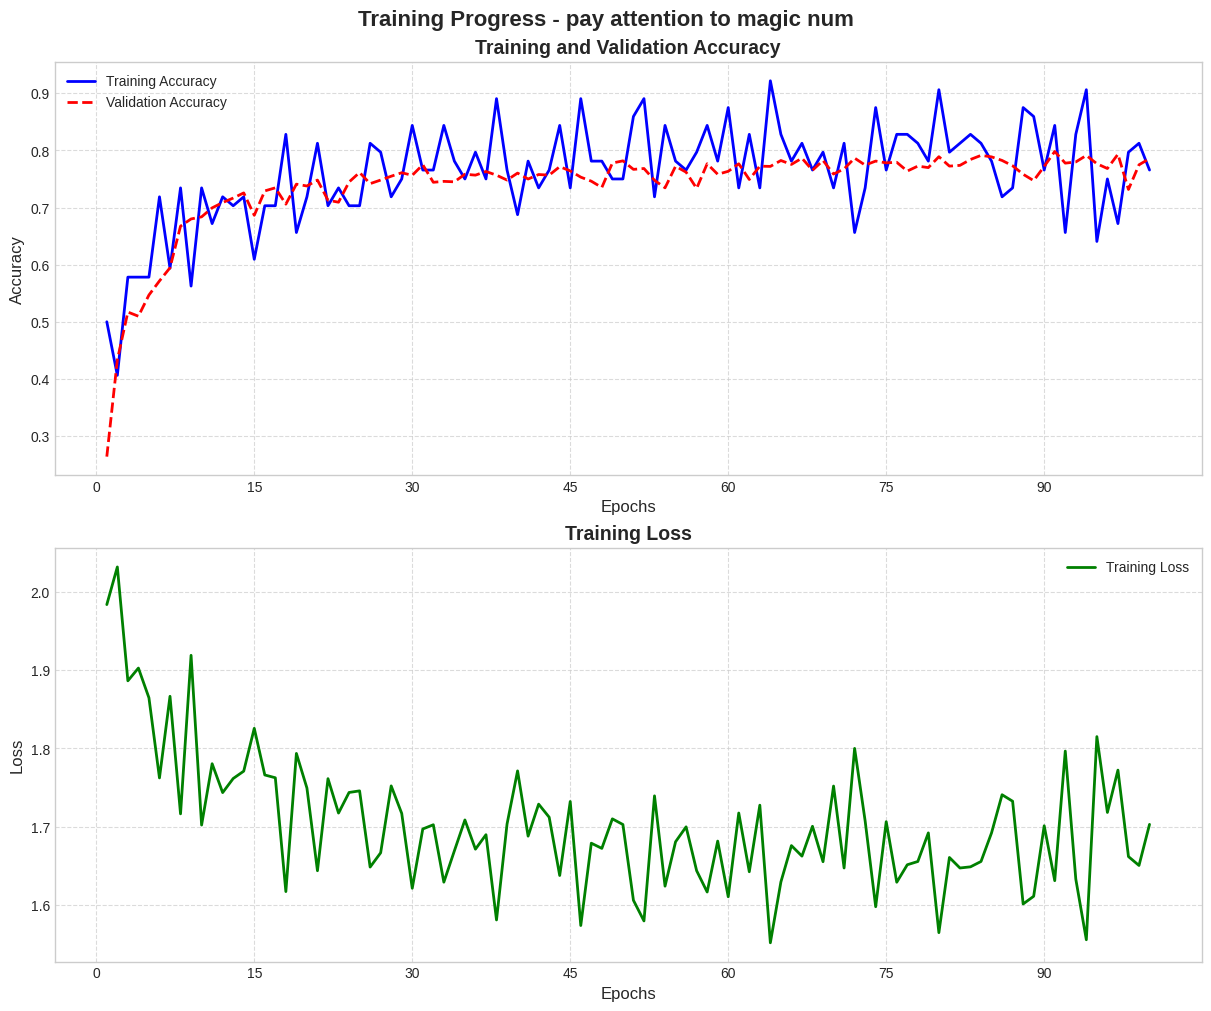

Training progress visualization saved to: training_logs/20250403_203736_GFJMK0_training_progress.png
Training information saved to: training_logs/20250403_203736_GFJMK0_training_info.txt


In [13]:

best_accuracy = 0.0
counter = 0


epoch_train_acc_list = []
epoch_train_loss_list = []
epoch_test_acc_list = []
# 训练模型
for epoch in range(hyperparameters['num_epochs']):
    train_acc, train_loss = train_model(epoch)
    test_acc = test_model(epoch)

    # early stopping
    if EARLY_STOP:
        if (test_acc > best_accuracy):
            best_accuracy = test_acc
            counter = 0
        else:
            counter += 1
            print(f"Early stopping counter: {counter}")
            if counter > hyperparameters['early_stop_patience']:
                print("Early stopping")
                break
    
    epoch_train_acc_list.append(train_acc)
    epoch_train_loss_list.append(train_loss)
    epoch_test_acc_list.append(test_acc)


message = input("Please type some information here as mdescription:\n    ")
visualize_training_progress(
        train_acc_list=epoch_train_acc_list,
        train_loss_list=epoch_train_loss_list,
        test_acc_list=epoch_test_acc_list,
        hyperparameters=hyperparameters,
        model_architecture=str(model),
        description=message,
        save_dir="training_logs"
)
    